In [1]:
import sys
sys.path.append("../..")
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

from transport_nets.models import NVP
from transport_nets.distributions import BananaFlow

from tqdm import trange

tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
#target data
num_samples = 10000
params = (0.5,0.1,0.05,0.0)
bFlow = BananaFlow(params)
target = bFlow.sample(num_samples)

# Create model object
nvp = NVP(output_dim=2,num_layers=6,num_masked=1, neuron_list=[100,100])

# Create optimizer and compile nvp with it
opt = tf.keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-08)
nvp.compile(opt)

# Define training options
n_epochs = 50
batch_size = 200

# Put the target data in a format the tf likes.
dataset = tf.data.Dataset.from_tensor_slices(target)
dataset = dataset.shuffle(buffer_size=num_samples).batch(batch_size)

# Train the model with the new callback
nvp.batch_norm_mode(True)
history = nvp.fit(dataset, epochs=n_epochs)  # Pass callback to training

# Set the training variables to not update when doing passes
nvp.batch_norm_mode(False)

Epoch 1/50
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
50/50 [==============================] - 1s 22ms/step - Negative Log Likelihood: -0.2208
Epoch 2/50
50/50 [==============================] - 1s 24ms/step - Negative Log Likelihood: -0.6096
Epoch 3/50
50/50 [==============================] - 1s 23ms/step - Negative Log Likelihood: -0.7062
Epoch 4/50
50/50 [==============================] - 1s 24ms/step - Negative Log Likelihood: -0.7553
Epoch 5/50
50/50 [==============================] - 1s 25ms/step - Negative Log Likelihood: -0.7760
Epoch 6/50
50/50 [==============================] - 1s 24ms/step - Negative Log Likelihood: -0.7912
Epoch 7/50
50/50 [==============================] - 1s 25ms/step - Neg

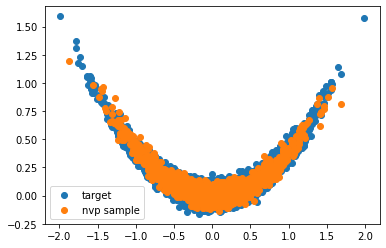

In [3]:
# checking that nvp learned joint distribution 
nvp_sample = nvp.sample(2000)
plt.scatter(target[:,0],target[:,1],label='target')
plt.scatter(nvp_sample[:,0],nvp_sample[:,1],label='nvp sample')
plt.legend()

### Pre-Conditioner Training Scheme
Have already trained invertible generator $f$. Want to train
pre-generator $\hat{f}$ to get conditional samples $x_1 \sim p(x_1|x_2=x_2^*)$.

<img src="images/pre-conditioner-training-diagram.png" width=600px>

Want to fit composed flow model $f\circ \hat{f}$ to smoothed distribution $p(x_1,x_2 | \hat{x_2} = x_2^*)$. By minimizing KL divergence between two distributions the objective function becomes
<img src="images/pre-conditioner-objective.png" width=400px>

In [9]:
from transport_nets.models import ComposedFlow
#pre-conditioner (structured noise)
nvp_pre = NVP(output_dim=2,num_layers=8,num_masked=1,neuron_list=[100,100])
_ = nvp_pre.sample(1000)
#x2_obs should be in list (rank 1)
x2_obs = [0.5]
lr = 1e-5
beta_1 = 0.9
beta_2 = 0.999
opt_pre = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=beta_1, beta_2=beta_2, epsilon=1e-6)
output_dim= 2
composedFlow = ComposedFlow(nvp,nvp_pre,x2_obs,output_dim,opt_pre)

epochs = 2000
batch_size = 50
sigma = 0.05 # whitening noise
composedFlow.train_pre_conditioner(epochs,batch_size,sigma)
nvp_pre.batch_norm_mode(False)

loss: 9.952 : 100%|██████████| 2000/2000 [00:47<00:00, 41.86it/s] 


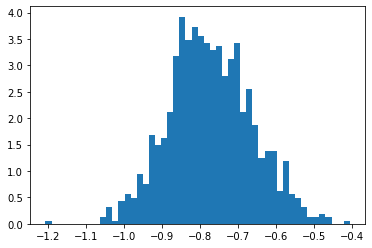

In [10]:
# Should be bi-modal distribution
# Will usually collapse on just one of the modes
X1 = composedFlow.sample(1000)
plt.hist(X1[:,0],50,density=True);